# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **shift + enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

#  Applying Reinforcement Learning on Price Data
You have already applied the RL model to a synthetic time series. Now it's time to apply that model on actual price data.

In this notebook, you will learn how to run the RL model on price and see the reinforcement learning strategy performance.
To do this, you need to follow these steps:

1. [Import modules](#Import_modules)
1. [Read price data](#Read_price_data)
1. [Run the RL model on the price data](#RL_run)
1. [Analyse strategy performance](#analyse)
1. [Result analysis](#results)

<a id='Import_modules'></a> 
## Import modules

In [1]:
!echo $VIRTUAL_ENV
# Import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

import os
import sys
sys.path.append("..")
print(sys.executable)
# Import Quantra RL libraries
from data_modules.quantra_reinforcement_learning import run
from data_modules.quantra_reinforcement_learning import reward_exponential_pnl
from data_modules.quantra_reinforcement_learning import trade_analytics

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras


/tmp/ipykernel_3836906/2279997455.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


/mnt/datadisk/sharedPrograms/venv/DLR/bin/python


In [2]:
use_cpu = False

<a id='Read_price_data'></a>
## Read price data

In [3]:
# print('keras v', keras.__version__)
# print('tf keras v', tf.keras.__version__)
# print('tf v', tf.__version__)
# # to do: try non eager execution graph?
# print('tf eager execution', tf.executing_eagerly())

# #turn off cryptic warnings, Note that you might miss important warnings! If unexpected stuff is happening turn it on!
# #https://github.com/tensorflow/tensorflow/issues/27023
# #Thanks @Mrs Przibylla
# #'1' = Infos, '2' = warnings, '3' = Errors
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# # with tf.Session() as sess:
# #     devices = sess.list_devices()
# # print(devices)
# devices = tf.config.experimental.list_physical_devices()
# print(devices)

# # do not assign complete gpu-memory but grow it as needed
# # allows to run multiple models at once (otherwise whole gpu memory gets allocated/gpu gets blocked)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        raise e

# ###Define Model and MirroredStrategy (for mulit-gpu usage) - shall be initiated at the beginning of the program
# # Create a MirroredStrategy and pass the GPUs
# if not use_cpu:
#     gpus = [0,1,2]
#     gpus = ["GPU:" + str(i) for i in gpus]
#     # https://keras.io/guides/distributed_training/
#     print('gpus', gpus)
#     strategy = tf.distribute.MirroredStrategy(gpus)
#     print('Number of GPUs MirroredStrategy: {}'.format(strategy.num_replicas_in_sync))
# elif use_cpu:
#     cpus = list(range(40))
#     cpus = ["CPU:" + str(i) for i in cpus]
#     # https://keras.io/guides/distributed_training/
#     print('cpus', cpus)
#     strategy = tf.distribute.MirroredStrategy(cpus)
#     print('Number of CPUs MirroredStrategy: {}'.format(strategy.num_replicas_in_sync))

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Price data is stored in data_modules
path = os.path.join('..','data_modules','PriceData5m.bz2')

# Read the price data
bars5m = pd.read_pickle(path)

# Display the last 5 entries of price data
bars5m.tail()

Num GPUs Available:  3


,open,high,low,close,volume
Time,,,,,
2020-08-31 15:40:00-04:00,350.44,350.750,350.433,350.692,658254.0
2020-08-31 15:45:00-04:00,350.71,350.733,350.330,350.680,842439.0
2020-08-31 15:50:00-04:00,350.69,351.270,350.640,351.210,1640390.0
2020-08-31 15:55:00-04:00,351.20,351.300,350.565,350.580,1890384.0
2020-08-31 16:00:00-04:00,350.59,350.730,349.770,349.770,3910688.0


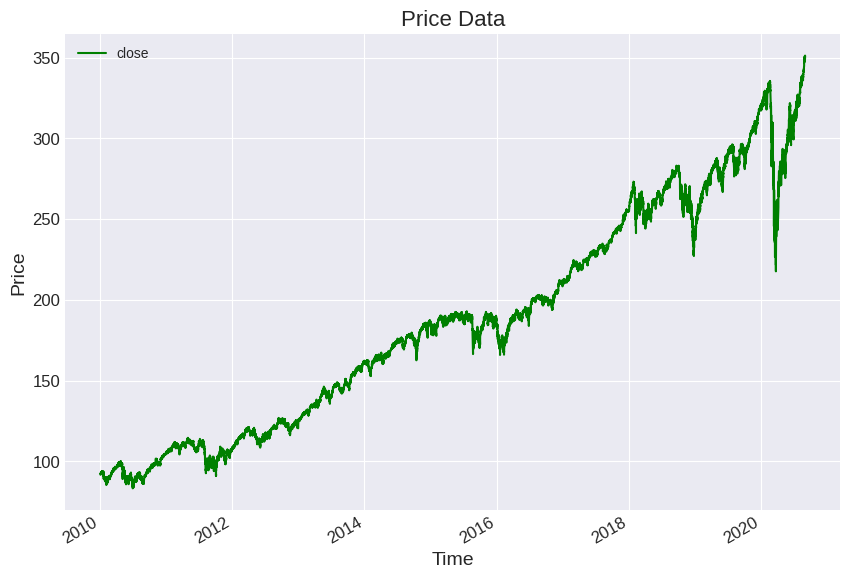

In [5]:
# Define the figure size for the price data
bars5m['close'].plot(figsize=(10, 7), color='g')

# Add legend to the axis
plt.legend()

# Add labels
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Price Data', fontsize=16)
    
# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()

<a id='RL_run'></a>
## Run the RL model on the price data

In [6]:
"""
For running the RL model on the price data, you need to 
set the configuration parameters.
These configuration parameters are hyperparameters for the 
RL model and the ANN used in it.
"""
rl_config = {
    
             'LEARNING_RATE': 0.00001,
             'LOSS_FUNCTION': 'mse',
             'ACTIVATION_FUN': 'relu',
             'NUM_ACTIONS': 3,
             'HIDDEN_MULT': 2,
             'DISCOUNT_RATE': 0.9,
             'LKBK': 30,
             'BATCH_SIZE': 1024,
             'MAX_MEM': 600,
             'EPSILON': 0.0001,
             'EPS_MIN': 0.001,
             'START_IDX': 5000,
             'WEIGHTS_FILE': '../data_modules/indicator_model_price_data.h5',
             'TRADE_FILE': '../data_modules/trade_logs_price_data.bz2',
             'REPLAY_FILE': '../data_modules/memory_price_data.bz2',
             'RF': reward_exponential_pnl,
             'TEST_MODE': False,
             'PRELOAD': False,
             'UPDATE_QR': True
}

In [ ]:
"""
Run the RL model on the price data
Note: To run in a local machine, please change the `TEST_MODE` to 
`False` in `rl_config`
"""
# with strategy.scope():
run(bars5m, rl_config)

2023-01-11 13:11:54.454471: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 13:11:55.267034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 611 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6
2023-01-11 13:11:55.267513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46176 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:c1:00.0, compute capability: 8.6
2023-01-11 13:11:55.267890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 wit

r_time:13:11:58 11.01.2023 | Trade:001 | pos:1 | len:5 | approx_cum_ret:-0.30% | trade_ret:-0.30% | eps:1.0010 | t_time:2010-04-07 10:55:00-04:00 | idx:5008
r_time:13:13:04 11.01.2023 | Trade:002 | pos:1 | len:32 | approx_cum_ret:-0.24% | trade_ret:0.07% | eps:0.0635 | t_time:2010-04-07 14:20:00-04:00 | idx:5049


<a id='analyse'></a>
## Analyse strategy performance for the full dataset

Now you will analyse the strategy performance by plotting the returns and drawdown and by calculating a few performance metrics.

You can use the `trade_analytics` function from `quantra_reinforcement_learning` module to perform the analysis

In [ ]:
# Call the trade_analytics function
with strategy.scope():
    trade_analytics_df = trade_analytics(rl_config['TRADE_FILE'], bars5m, "Price Data")

<a id='results'></a>
## Result analysis

The RL model performs fairly well on the actual price data. It took some time to learn the pattern, and after the year 2012, it has given consistent returns.

Note that the price dips a lot in 2019 and in 2020(corona effect), but the RL model handles it well.

In 2019 it manages to keep the returns fairly flat in a crashing market.

In 2020, the returns drawdown due to the price crash, but the model makes up for this drawdown remarkably well in a short timeframe.

## Tweak the code
You can tweak the code in the following ways:

1. Use different data sets: backtest and try out the model on different stock data
1. Change the settings of the configuration parameters to see how the RL model performs on changing these settings. A few setting you may try changing:
    1. learning rate (`LEARNING_RATE`)
    1. lookback period (`LKBK`)
    1. batch size (`BATCH_SIZE`)
    1. maximum memory buffer (`MAX_MEM`)
    1. the epsilon (`EPSILON` or `EPS_MIN`) values 

In the upcoming units, you will learn how to automate your trades and do paper/live trades.
<br><br>